In [468]:
import pyspark as ps   
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import geopandas
import scipy.stats as stats
import statsmodels
from statsmodels.stats.proportion import proportions_ztest
from pyspark.sql import functions as F

spark = ps.sql.SparkSession.builder \
            .master("local[4]") \
            .appName("housing accessibility") \
            .getOrCreate()
sc = spark.sparkContext
spark.conf.set("spark.sql.caseSensitive", "true")


In [276]:
housing = spark.read.option("header", True).csv('housing-wheelchairs-DFE.csv').drop("url", \
                    "_trusted_judgments", "_last_judgment_at", "_golden",\
                    "house_types_gold", "house_types_gold_reason", "residential_yes_gold",\
                    "residential_yes_gold_reason", "_golden", "_unit_state", "residential_yes:confidence",\
                    "residential_yes", "house_types", "house_types:confidence")\
                    .withColumnRenamed("sidewalk_ok:confidence","sidewalk_ok_confidence")\
                    .withColumnRenamed("aadress", "address")\
                    .withColumn("street",F.split(F.col("address"),",").getItem(0))\
                    .withColumn("city",F.split(F.col("address"),",").getItem(1))\
                    .withColumn("state_zip",F.split(F.col("address"),",").getItem(2))\
                    .withColumn("country",F.split(F.col("address"),",").getItem(3))\
                    .withColumn("state",F.split(F.col("state_zip")," ").getItem(1))\
                    .withColumn("zip",F.split(F.col("state_zip")," ").getItem(2))
housing.createOrReplaceTempView("housing")
housing.printSchema()

root
 |-- _unit_id: string (nullable = true)
 |-- sidewalk_ok: string (nullable = true)
 |-- sidewalk_ok_confidence: string (nullable = true)
 |-- address: string (nullable = true)
 |-- lat: string (nullable = true)
 |-- long: string (nullable = true)
 |-- sidewalk_ok_gold: string (nullable = true)
 |-- sidewalk_ok_gold_reason: string (nullable = true)
 |-- street: string (nullable = true)
 |-- city: string (nullable = true)
 |-- state_zip: string (nullable = true)
 |-- country: string (nullable = true)
 |-- state: string (nullable = true)
 |-- zip: string (nullable = true)



In [332]:
housing.coalesce(1).write.option("header", "true").csv("housing_cleaned.csv")

In [334]:
# count of sidewalk_ok_reason
query0 = ('''
         SELECT COUNT(sidewalk_ok_gold_reason)
         FROM housing
         WHERE sidewalk_ok_gold_reason = 'There is a sidewalk available, it does look safe and wide enough'
         OR sidewalk_ok_gold_reason = 'The sidewalk/pedestrian path is missing.'
         ;
         ''')

sidewalk_ok_reaason = spark.sql(query0).toPandas()

sidewalk_ok_reaason #pd df

,count(sidewalk_ok_gold_reason)
0,35


In [278]:
# count of sidewalk_not_ok_reason
query0 = ('''
         SELECT COUNT(sidewalk_ok_gold_reason)
         FROM housing
         WHERE sidewalk_ok_gold_reason = 'The sidewalk/pedestrian path is not safe \
         for wheelchairs ��� it is not continuous or not wide enough or there seems \
         to be other issues with the sidewalk'
         ;
         ''')

sidewalk_not_ok_reaason = spark.sql(query0).toPandas()

sidewalk_not_ok_reaason #pd df

,count(sidewalk_ok_gold_reason)
0,0


In [310]:
# national sidewalk_ok
query1 = ('''
         SELECT *
         FROM housing
         WHERE sidewalk_ok = 'yes'
         ;
         ''')

sidewalk_ok = spark.sql(query1).toPandas()
count_row_US_ok = sidewalk_ok.shape[0]
count_row_US_ok
# sidewalk_ok #pd df

5480

In [309]:
# national sidewalk_not_ok
query2 = ('''
         SELECT *
         FROM housing
         WHERE sidewalk_ok = 'no'
         ;
         ''')

sidewalk_not_ok = spark.sql(query2).toPandas()
count_row_US_not_ok = sidewalk_not_ok.shape[0]
count_row_US_not_ok
# sidewalk_not_ok #pd df

945

In [311]:
# New York sidewalk_ok
query4 = ('''
         SELECT *
         FROM housing
         WHERE sidewalk_ok = 'yes' AND state = 'NY'
         ;
         ''')

sidewalk_ok_NY = spark.sql(query4).toPandas()
count_row_NY_ok = sidewalk_ok_NY.shape[0]
count_row_NY_ok
#sidewalk_ok_NY #pd df

315

In [316]:
# New York sidewalk_not_ok
query5 = ('''
         SELECT *
         FROM housing
         WHERE sidewalk_ok = 'no' AND state = 'NY'
         ;
         ''')

sidewalk_not_ok_NY = spark.sql(query5).toPandas()
count_row_NY_not_ok = sidewalk_not_ok_NY.shape[0]
count_row_NY_not_ok
#sidewalk_not_ok_NY #pd df

40

In [345]:
# New York sidewalk_ok_caveat
query8 = ('''
         SELECT COUNT(*)
         FROM housing
         WHERE state = 'NY' AND
         sidewalk_ok_gold_reason = 'There is a sidewalk available, it does look safe and wide enough'
         ;
         ''') 
count_sidewalk_ok_caveat_NY = spark.sql(query8).toPandas()
count_sidewalk_ok_caveat_NY

,count(1)
0,1


In [460]:
# total NY
query10 = ('''
         SELECT COUNT(*)
         FROM housing
         WHERE state = 'NY'
         ;
         ''') 
total_NY = spark.sql(query10).toPandas()
total_NY

,count(1)
0,489


In [337]:
# California sidewalk_ok
query6 = ('''
         SELECT *
         FROM housing
         WHERE sidewalk_ok = 'yes' AND state = 'CA'
         ;
         ''')

sidewalk_ok_CA = spark.sql(query6).toPandas()
count_row_CA_ok = sidewalk_ok_CA.shape[0]
count_row_CA_ok
#sidewalk_ok_CA #pd df

1376

In [315]:
# California sidewalk_not_ok
query7 = ('''
         SELECT *
         FROM housing
         WHERE sidewalk_ok = 'no' AND state = 'CA'
         ;
         ''')

sidewalk_not_ok_CA = spark.sql(query7).toPandas()
count_row_CA_not_ok = sidewalk_not_ok_CA.shape[0]
count_row_CA_not_ok
#sidewalk_not_ok_CA #pd df

205

In [347]:
# California sidewalk_ok_caveat
query8 = ('''
         SELECT COUNT(*)
         FROM housing
         WHERE state = 'CA' AND
         sidewalk_ok_gold_reason = 'There is a sidewalk available, it does look safe and wide enough'
         ;
         ''') 
count_sidewalk_ok_caveat_CA = spark.sql(query8).toPandas()
count_sidewalk_ok_caveat_CA

,count(1)
0,1


In [462]:
# total CA
query11 = ('''
         SELECT COUNT(*)
         FROM housing
         WHERE state = 'CA'
         ;
         ''') 
total_CA = spark.sql(query11).toPandas()
total_CA

,count(1)
0,2440


In [407]:
# Washington sidewalk_ok
query9 = ('''
         SELECT *
         FROM housing
         WHERE sidewalk_ok = 'yes' AND state = 'WA'
         ;
         ''')

sidewalk_ok_WA = spark.sql(query9).toPandas()
count_row_WA_ok = sidewalk_ok_WA.shape[0]
count_row_WA_ok
#sidewalk_ok_CA #pd df

7

In [281]:
sidewalk_ok.count()

_unit_id                   5480
sidewalk_ok                5480
sidewalk_ok_confidence     5480
address                    5480
lat                        5479
long                       5479
sidewalk_ok_gold             30
sidewalk_ok_gold_reason      33
street                     5480
city                       5480
state_zip                  5480
country                    5474
state                      5480
zip                        5466
dtype: int64

In [282]:
sidewalk_not_ok.count()

_unit_id                   945
sidewalk_ok                945
sidewalk_ok_confidence     945
address                    945
lat                        945
long                       945
sidewalk_ok_gold             9
sidewalk_ok_gold_reason      7
street                     945
city                       945
state_zip                  945
country                    940
state                      945
zip                        942
dtype: int64

In [283]:
sw_ok_gold_reason = pd.Series(sidewalk_ok['sidewalk_ok_gold_reason'])
sw_ok_gold_reason.unique()

array(['There is a sidewalk available, it does look safe and wide enough',
       None], dtype=object)

In [284]:
sw_not_ok_gold_reason = pd.Series(sidewalk_not_ok['sidewalk_ok_gold_reason'])
sw_not_ok_gold_reason.unique()


array(['The sidewalk/pedestrian path is not safe for wheelchairs ��� it is not continuous or not wide enough or there seems to be other issues with the sidewalk',
       None, 'The sidewalk/pedestrian path is missing.'], dtype=object)

In [285]:
sidewalk_ok_gdf = geopandas.GeoDataFrame(
    sidewalk_ok, geometry=geopandas.points_from_xy(sidewalk_ok.long, sidewalk_ok.lat))

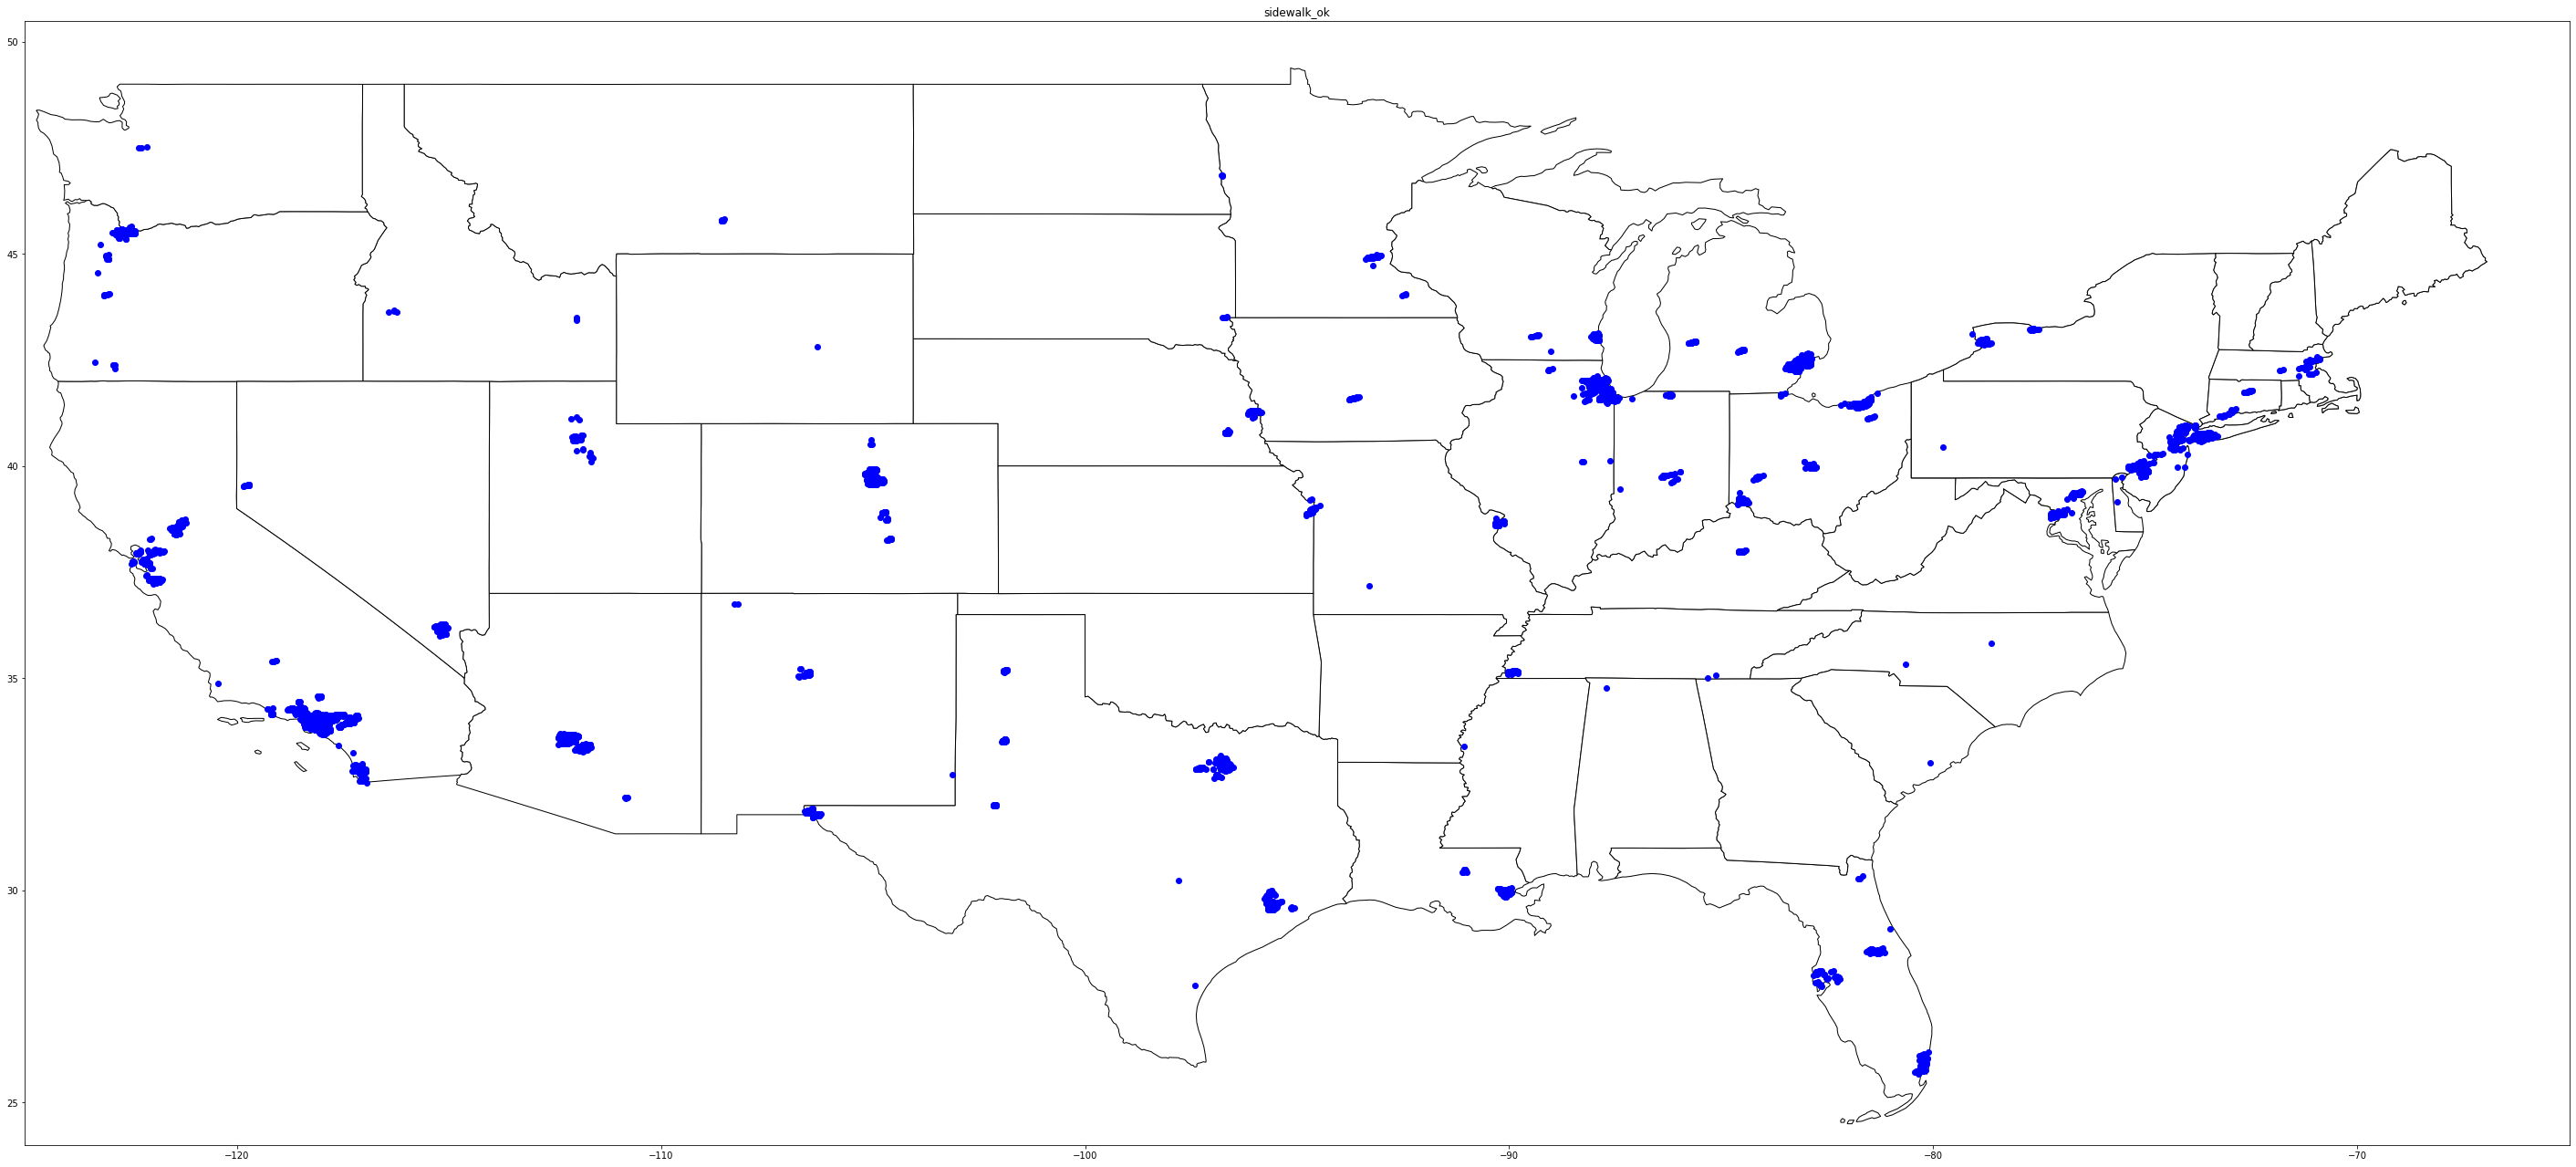

In [353]:
states = geopandas.read_file('/Users/nicolacave/dsi_galvanize/capstones/capstone1/geopandas-tutorial/data/usa-states-census-2014.shp')


ax = states.plot(
    color='white', edgecolor='black', figsize=(50,50))

# We can now plot our ``GeoDataFrame``.
sidewalk_ok_gdf.plot(ax=ax, color='blue')
ax.set_xlim(-125.00244, -65.00000)
ax.set_ylim(24.00000, 50.50000)
ax.set_title("sidewalk_ok")

plt.show()

In [354]:
sidewalk_not_ok_gdf = geopandas.GeoDataFrame(
    sidewalk_not_ok, geometry=geopandas.points_from_xy(sidewalk_not_ok.long, sidewalk_not_ok.lat))

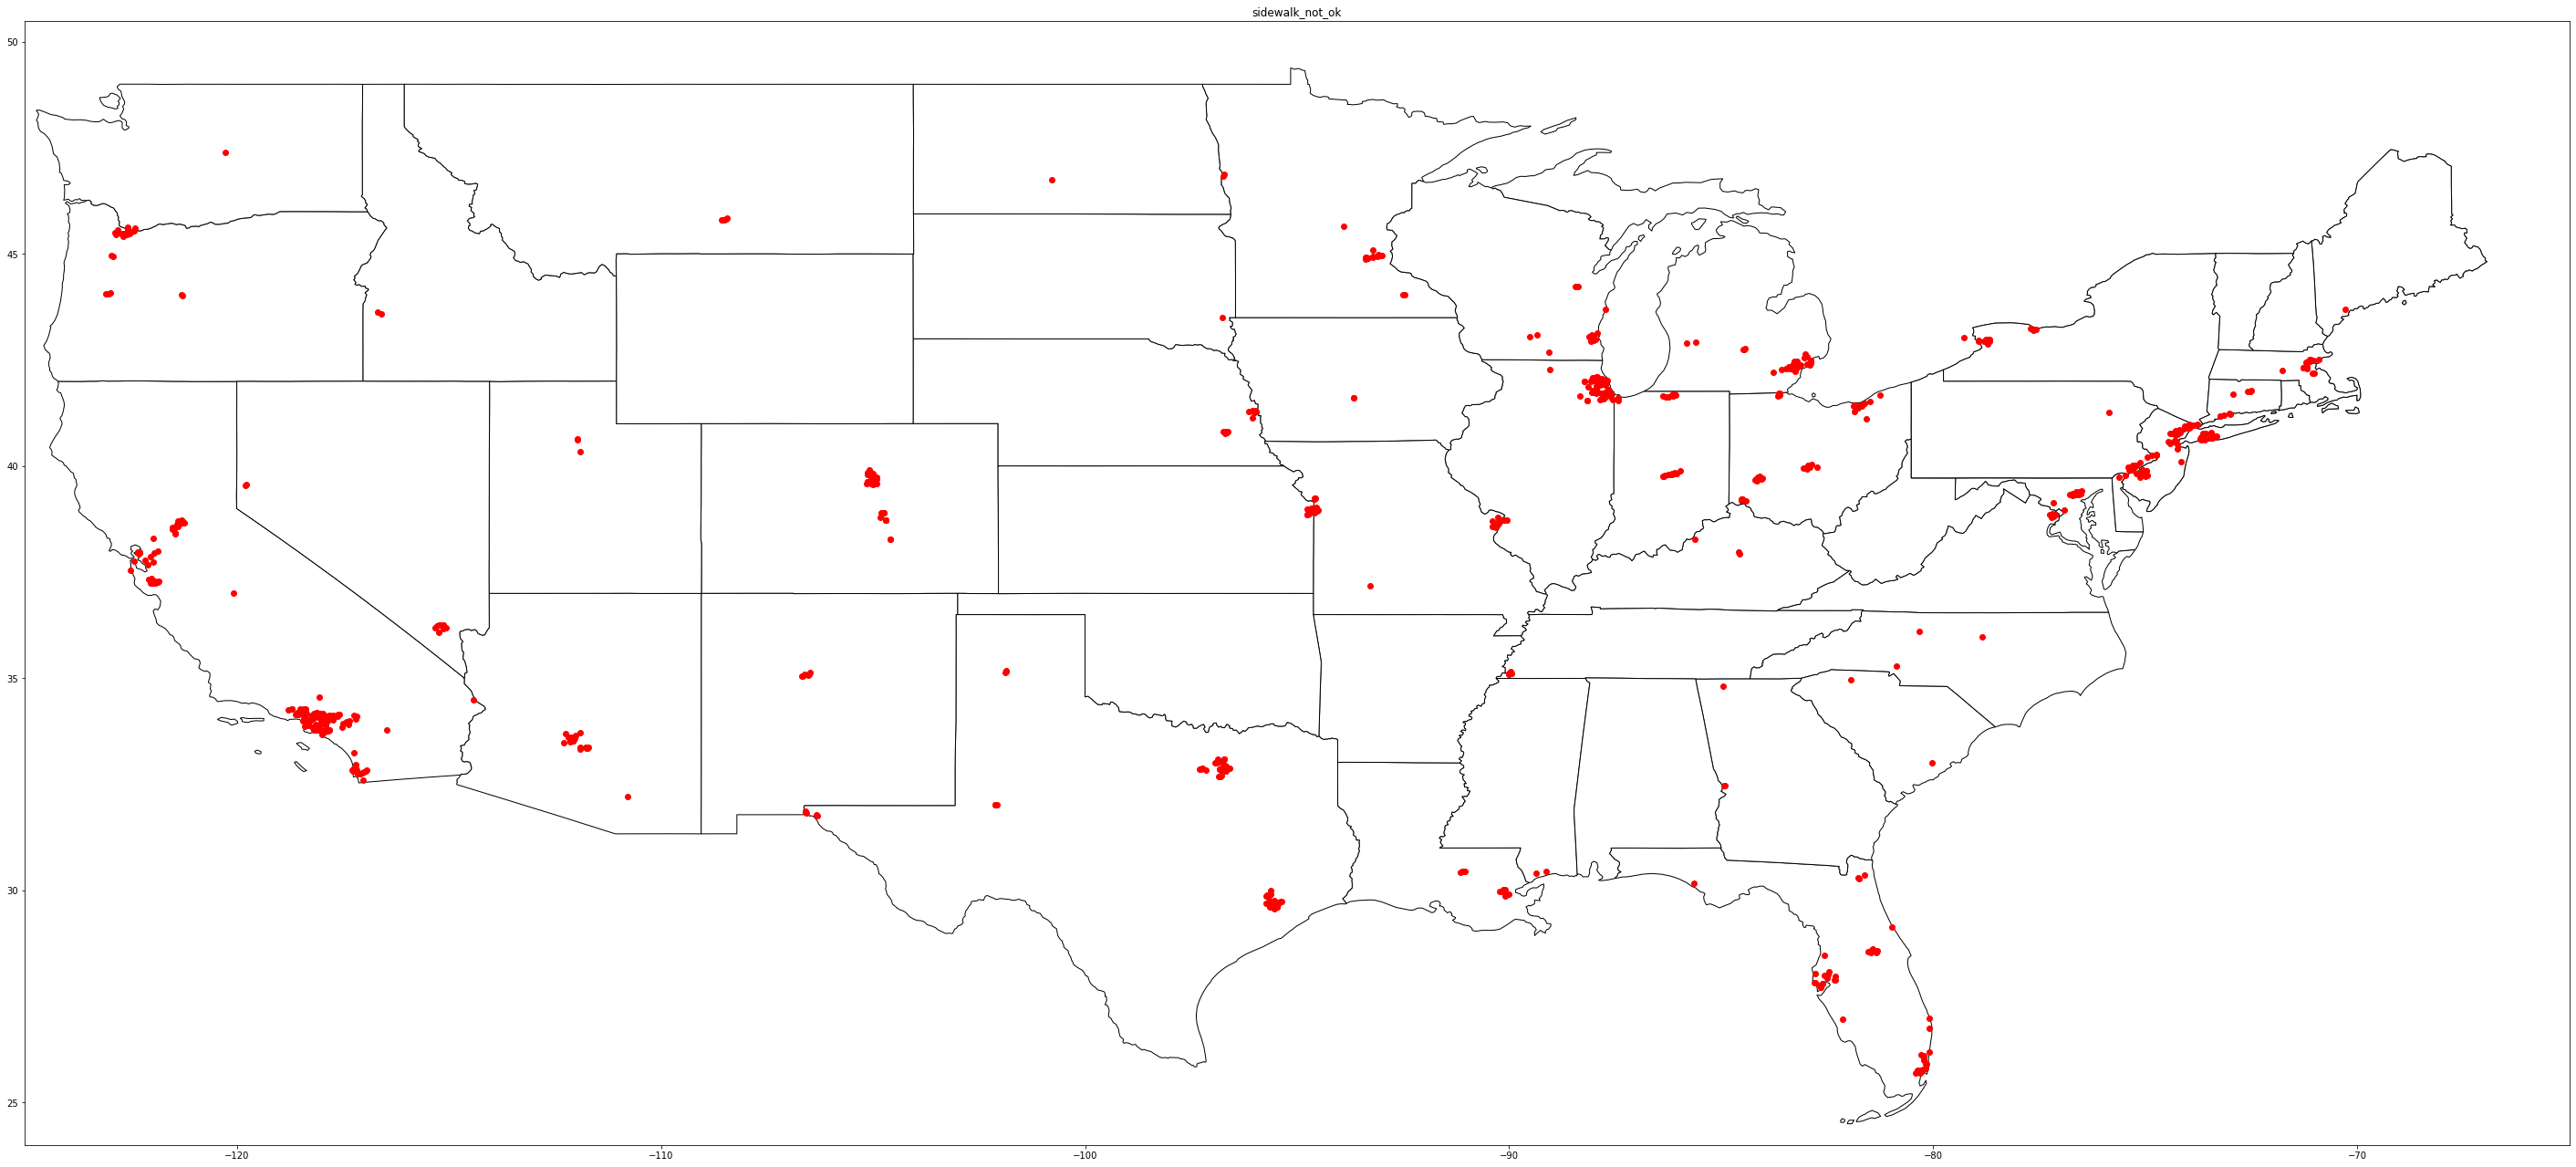

In [355]:
ax = states.plot(
    color='white', edgecolor='black', figsize=(50,50))

# We can now plot our ``GeoDataFrame``.
sidewalk_not_ok_gdf.plot(ax=ax, color='red')
ax.set_xlim(-125.00244, -65.00000)
ax.set_ylim(24.00000, 50.50000)
ax.set_title("sidewalk_not_ok")

plt.show()

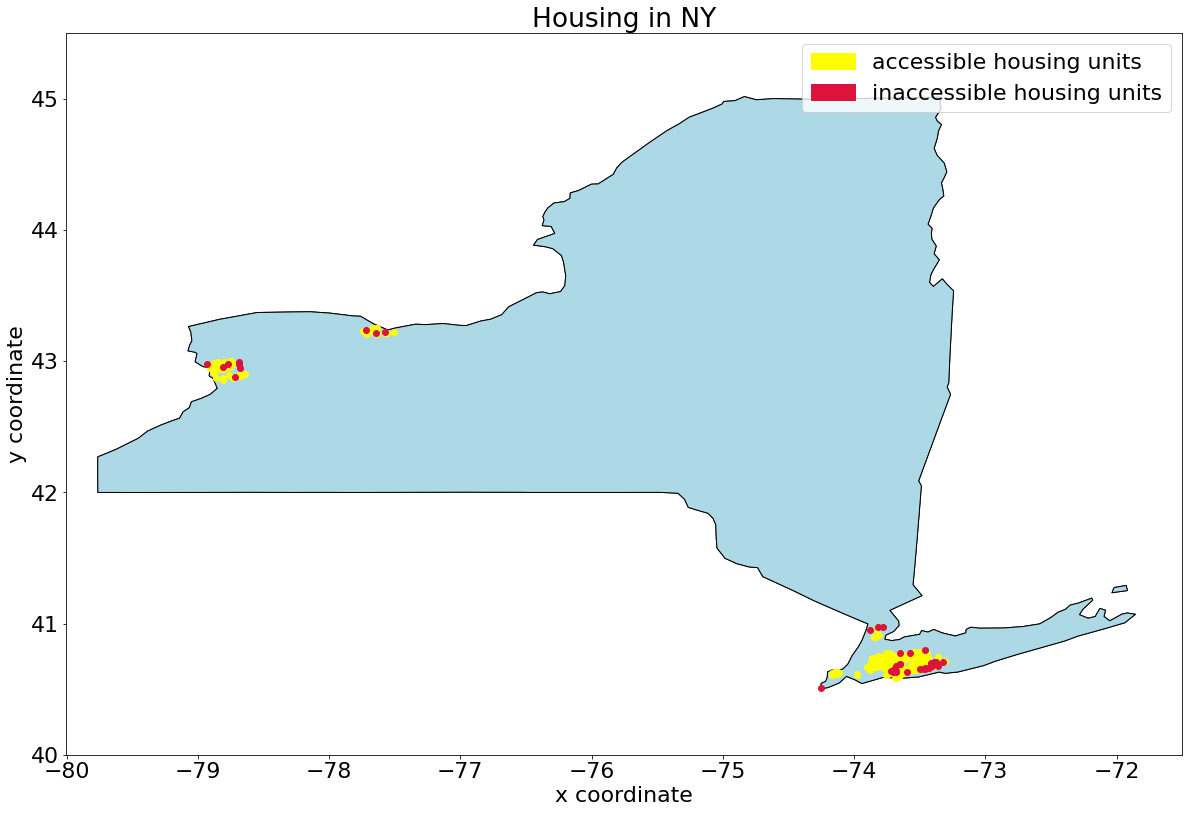

In [474]:
states = geopandas.read_file('/Users/nicolacave/dsi_galvanize/capstones/capstone1/geopandas-tutorial/data/usa-states-census-2014.shp')
NY = states[states['NAME'] == 'New York']
sidewalk_ok_NY_gdf = geopandas.GeoDataFrame(
                     sidewalk_ok_NY, geometry=geopandas.points_from_xy(sidewalk_ok_NY.long,\
                                                                       sidewalk_ok_NY.lat))
ax = NY.plot(
    color='lightblue', edgecolor='black', figsize=(20,20))

# We can now plot our ``GeoDataFrame``.
sidewalk_ok_NY_gdf.plot(ax=ax, color='yellow')
sidewalk_not_ok_NY_gdf.plot(ax=ax, color='crimson')
ax.set_xlim(-80.00244, -71.50000)
ax.set_ylim(40.00000, 45.50000)
ax.set_title("Housing in NY")
ax.set_xlabel("x coordinate")
ax.set_ylabel("y coordinate")
yellow_patch = mpatches.Patch(color='yellow', label='accessible housing units')
crimson_patch = mpatches.Patch(color='crimson', label='inaccessible housing units')
plt.legend(handles=[yellow_patch, crimson_patch])
plt.rcParams.update({'font.size': 40})
plt.savefig("housing_NY.png")
plt.show()




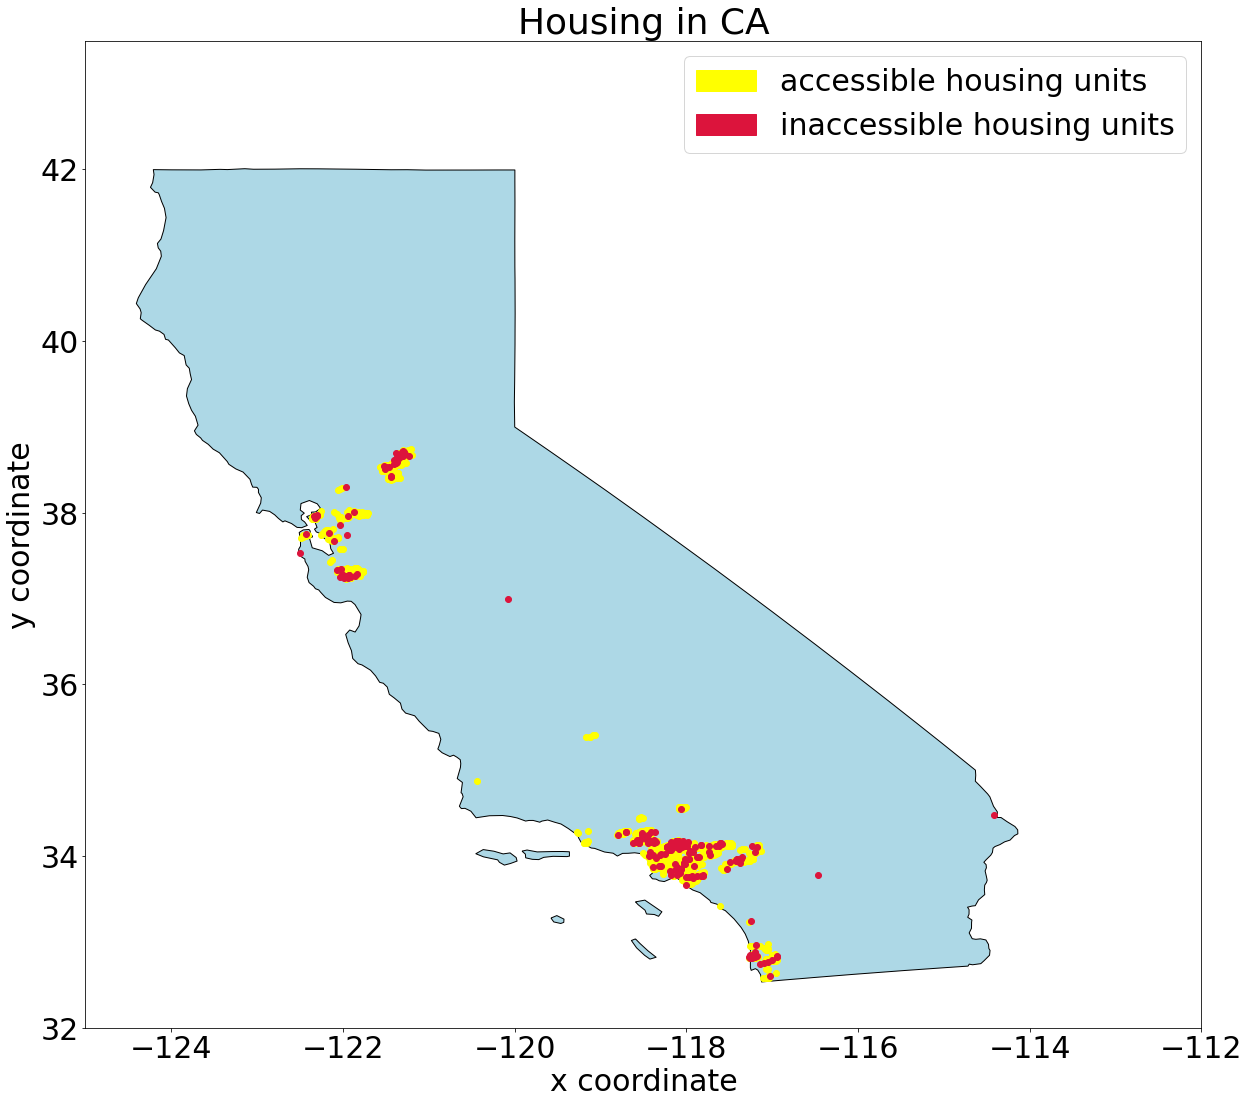

In [477]:
states = geopandas.read_file('/Users/nicolacave/dsi_galvanize/capstones/capstone1/geopandas-tutorial/data/usa-states-census-2014.shp')
CA = states[states['NAME'] == 'California']
sidewalk_ok_CA_gdf = geopandas.GeoDataFrame(
                     sidewalk_ok_CA, geometry=geopandas.points_from_xy(sidewalk_ok_CA.long,\
                                                                       sidewalk_ok_CA.lat))
ax = CA.plot(
    color='lightblue', edgecolor='black', figsize=(20,20))

# We can now plot our ``GeoDataFrame``.
sidewalk_ok_CA_gdf.plot(ax=ax, color='yellow')
sidewalk_not_ok_CA_gdf.plot(ax=ax, color='crimson')
ax.set_xlim(-125.00244, -112.00000)
ax.set_ylim(32.00000, 43.50000)
ax.set_title("Housing in CA")
ax.set_xlabel("x coordinate")
ax.set_ylabel("y coordinate")
yellow_patch = mpatches.Patch(color='yellow', label='accessible housing units')
crimson_patch = mpatches.Patch(color='crimson', label='inaccessible housing units')
plt.legend(handles=[yellow_patch, crimson_patch])
plt.rcParams.update({'font.size': 20})
plt.savefig("housing_CA.png")
plt.show()




In [461]:
# proportion of sidewalk_ok / total NY
315 / 489

0.6441717791411042

In [463]:
# proportion of sidewalk_ok / total CA
1376 / 2440

0.5639344262295082

In [292]:
# proportion of sidewalk_not_ok / total NY
40 / 

In [293]:
# proportion of sidewalk_not_ok / total CA
205 / 

In [469]:
# compute 2-tailed z-test
count = np.array([315, 1376])
nobs = np.array([489, 2440])
stat, pval = proportions_ztest(count, nobs)
print('{0:0.3f}'.format(pval))
statsmodels.stats.proportion.proportions_ztest(count, nobs, value=None, alternative='two-sided', prop_var=False)

0.001


(3.2783362429921157, 0.001044209312130665)

In [290]:
# proportion of sidewalk_ok_caveat / total NY 

In [ ]:
# proportion of sidewalk_ok_caveat / total CA

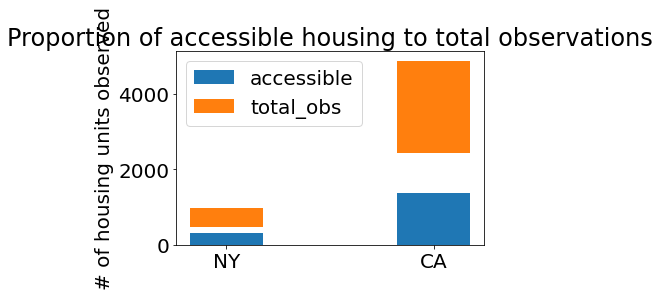

In [488]:

labels = ['NY', 'CA']
sidewalk_ok = [315, 1376]
total_obs = [489, 2440]
width = 0.35       # the width of the bars: can also be len(x) sequence

fig, ax = plt.subplots()

ax.bar(labels, sidewalk_ok, width, label='accessible')
ax.bar(labels, total_obs, width, bottom=total_obs,
       label='total_obs')

ax.set_ylabel('# of housing units observed')
ax.set_title('Proportion of accessible housing to total observations')
ax.legend()
plt.tight_layout()

plt.show()